In [2]:
!pip install --upgrade pip

# 各ライブラリインストール
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# 環境変数設定
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# findsparkで環境設定
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pip import main
main(['install','pyspark==2.4.5'])
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession\
      .builder\
      .getOrCreate()

  Using cached https://files.pythonhosted.org/packages/54/0c/d01aa759fdc501a58f431eb594a17495f15b88da142ce14b5845662c13f3/pip-20.0.2-py2.py3-none-any.whl
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [3]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-03-30 04:41:26--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-03-30 04:41:27--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-03-30 04:41:27--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet

In [4]:
df = spark.read.parquet('washing.parquet')

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [5]:
df.count()

2058

In [6]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [8]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False, 0.1).collect()

result_array[:15]

[228, 236, 244, 227, 235, 226, 239, 238, 226, 220, 229, 229, 238, 237, 224]

In [0]:
matplotlib inline

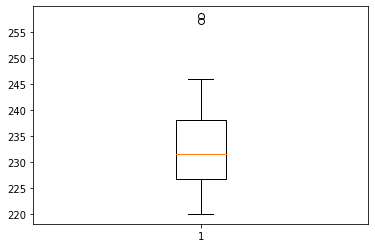

In [10]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

In [13]:
result = spark.sql("select voltage, ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False, 0.1).map(lambda row : (row.ts, row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage : ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage : ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808722910, 1547808734922, 1547808746929, 1547808749929, 1547808830981, 1547808836984, 1547808846029, 1547808855034, 1547808870039, 1547808876043, 1547808942124, 1547808945126, 1547808957136, 1547808966142, 1547808975148]
[221, 234, 222, 225, 227, 224, 233, 221, 231, 221, 234, 230, 221, 221, 238]


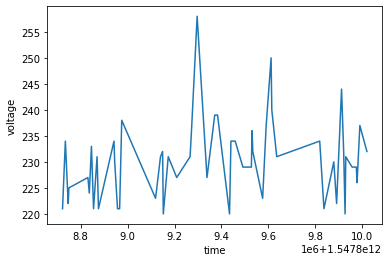

In [14]:
plt.plot(result_array_ts, result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [15]:
spark.sql("select min(ts), max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



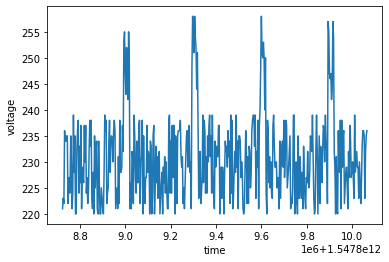

In [17]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [0]:
result_df = spark.sql(
"""
select hardness, temperature, flowrate from washing 
       where hardness is not null and 
       temperature is not null and
       flowrate is not null
""")
result_rdd = result_df.rdd.sample(False, 0.1).map(lambda row : (row.hardness, row.temperature, row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

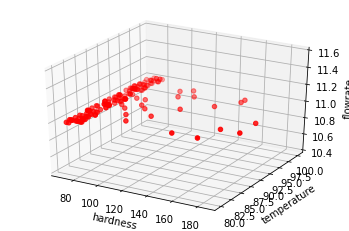

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

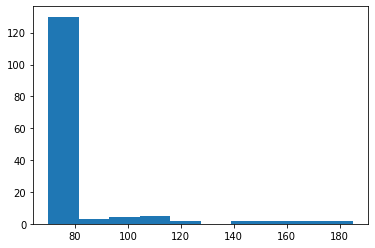

In [30]:
plt.hist(result_array_hardness)
plt.show()